In [1]:
import gdown

file_id = "1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb"
output = "food11.zip"

gdown.download(id=file_id, output=output, quiet=False)

import zipfile

with zipfile.ZipFile("food11.zip", "r") as zip_ref:
    zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb
From (redirected): https://drive.google.com/uc?id=1a0uuiylWnyGAr0JZVfhw2EPZ6XzcPtyb&confirm=t&uuid=dd83178b-8210-43cc-a5e0-a3c2e3e677fc
To: /content/food11.zip
100%|██████████| 134M/134M [00:03<00:00, 40.6MB/s]


In [2]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gc

In [ ]:
# Resize images to a fixed size (e.g., 256x256) for consistent batching
base_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Adjust to your dataset
    transforms.ToTensor(),          # Converts PIL Image to [0, 1] range
])

# dataset = datasets.ImageFolder(root='food11/train', transform=base_transform)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False)  # No shuffling for reproducibility

In [ ]:
def compute_mean_std(dataloader):
    # Initialize variables
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_pixels = 0

    for images, _ in dataloader:  # Ignore labels with "_"
        batch_samples = images.size(0)  # Batch size (B)
        images = images.view(batch_samples, images.size(1), -1)  # Flatten H and W
        mean += images.mean(2).sum(0)  # Sum channel means across the batch
        std += images.std(2).sum(0)    # Sum channel stds across the batch
        total_pixels += images.size(2) * batch_samples  # Total pixels per channel

    # Final mean and std (averaged over all pixels)
    mean /= total_pixels
    std /= total_pixels
    return mean, std

# mean, std = compute_mean_std(dataloader)
# print(f"Mean: {mean}\nStd: {std}")

In [3]:
mean = torch.tensor([8.5694e-06, 6.8283e-06, 5.1815e-06])
std = torch.tensor([3.4230e-06, 3.5909e-06, 3.5516e-06])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
num_epochs = 50
num_classes = 11

In [6]:
transform_train = transforms.Compose([
    # Geometric transforms (PIL-based)
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),

    # Color transforms (PIL-based)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),

    # Conversion to tensor
    transforms.ToTensor(),

    # Tensor-based operations
    transforms.Normalize(mean=mean, std=std),
])

In [7]:
transform_val = transforms.Compose([
    transforms.Resize(256),          # Maintain aspect ratio
    transforms.CenterCrop(256),      # Deterministic crop
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_dataset = datasets.ImageFolder(root="food11/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root="food11/validation", transform=transform_val)

# Part 1

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # channel widths for each conv
        C1, C2, C3, C4, C5 = 32, 64, 128, 256, 256

        self.features = nn.Sequential(
            # ── Conv 1 ── 256×256 → 256×256
            nn.Conv2d(3,  C1, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(C1),       # ← single BatchNorm
            nn.ReLU(),

            # ── Conv 2 ── 256×256 → 128×128
            nn.Conv2d(C1, C2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # ── Conv 3 ── 128×128 → 128×128
            nn.Conv2d(C2, C3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 4 ── 128×128 → 128×128
            nn.Conv2d(C3, C4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 5 ── 128×128 → 128×128
            nn.Conv2d(C4, C5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Single Pool ── 128×128 → 16×16
            nn.MaxPool2d(kernel_size=8),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C5 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
class CNN_Residual(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Residual, self).__init__()
        # channel widths for each conv
        C1, C2, C3, C4, C5 = 32, 64, 128, 256, 256

        self.first_block = nn.Sequential(
            # ── Conv 1 ── 256×256 → 256×256
            nn.Conv2d(3,  C1, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(C1),       # ← single BatchNorm
            nn.ReLU(),

            # ── Conv 2 ── 256×256 → 128×128
            nn.Conv2d(C1, C2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # ── Conv 3 ── 128×128 → 128×128
            nn.Conv2d(C2, C3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 4 ── 128×128 → 128×128
            nn.Conv2d(C3, C4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.second_block = nn.Sequential(
            # ── Conv 5 ── 128×128 → 128×128
            nn.Conv2d(C4, C5, kernel_size=3, stride=1, padding=1),
        )
        self.third_block = nn.Sequential(
            nn.ReLU(),

            # ── Single Pool ── 128×128 → 16×16
            nn.MaxPool2d(kernel_size=8),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C5 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.first_block(x)
        out = self.second_block(x)
        out = out + x
        out = self.third_block(out)
        out = self.classifier(out)
        return out


In [11]:
def test_model(batch_size, learning_rate, model):
    result = {}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)

    val_accs = []
    train_losses = []

    for epoch in tqdm(range(num_epochs), desc=f"Epoch: "):  # Number of epochs
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accs.append(100 * val_correct / val_total)

    result["loss"] = train_losses
    result["val_accuracy"] = val_accs
    return result

In [ ]:
lr_list = [0.0003, 0.0004, 0.0005]
batch_list = [128, 64]
results = {}

torch.cuda.empty_cache()     # free up cached memory
gc.collect()                 # run Python GC to clear any lingering refs

for lr in lr_list:
    for batch in batch_list:
        # 1) build a fresh model & send to GPU
        model = CNN(num_classes).to(device)

        # 2) training/testing
        results[(lr, batch)] = test_model(batch, lr, model)

        # 3) cleanup everything that lives on the GPU
        del model                    # remove model reference
        torch.cuda.empty_cache()     # free up cached memory
        gc.collect()                 # run Python GC to clear any lingering refs

results_residual = {}

for lr in lr_list:
    for batch in batch_list:
        # 1) build a fresh model & send to GPU
        model = CNN_Residual(num_classes).to(device)

        # 2) training/testing
        results_residual[(lr, batch)] = test_model(batch, lr, model)

        # 3) cleanup everything that lives on the GPU
        del model                    # remove model reference
        torch.cuda.empty_cache()     # free up cached memory
        gc.collect()                 # run Python GC to clear any lingering refs

Epoch: 100%|██████████| 50/50 [25:44<00:00, 30.90s/it]


In [12]:
def draw_graphs(results, loss_title, acc_title, figsize=(14, 7)):
    epochs = range(1, 51)

    # Training Loss
    plt.figure(figsize=figsize)
    for (lr, bs), h in results.items():
        plt.plot(epochs, h['loss'], label=f"lr={lr}, bs={bs}")
    plt.title(loss_title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Validation Accuracy
    plt.figure(figsize=figsize)
    for (lr, bs), h in results.items():
        plt.plot(epochs, h['val_accuracy'], label=f"lr={lr}, bs={bs}")
    plt.title(acc_title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

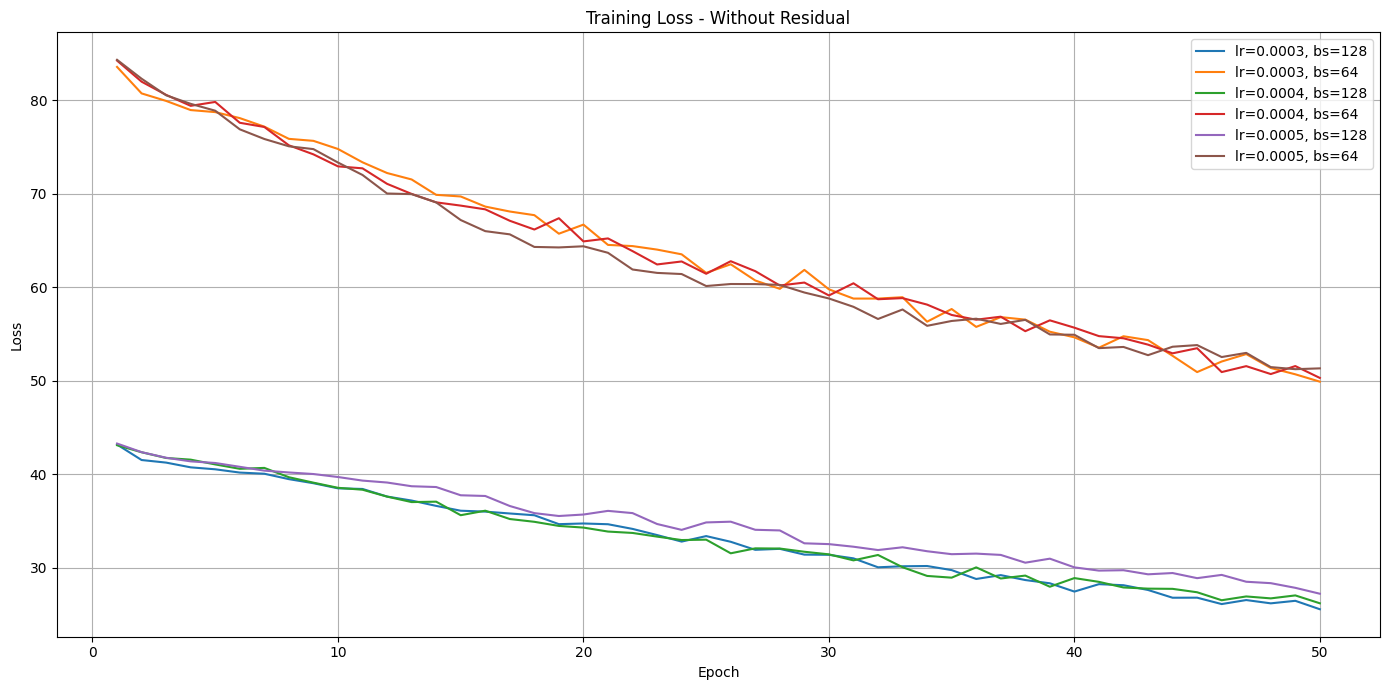

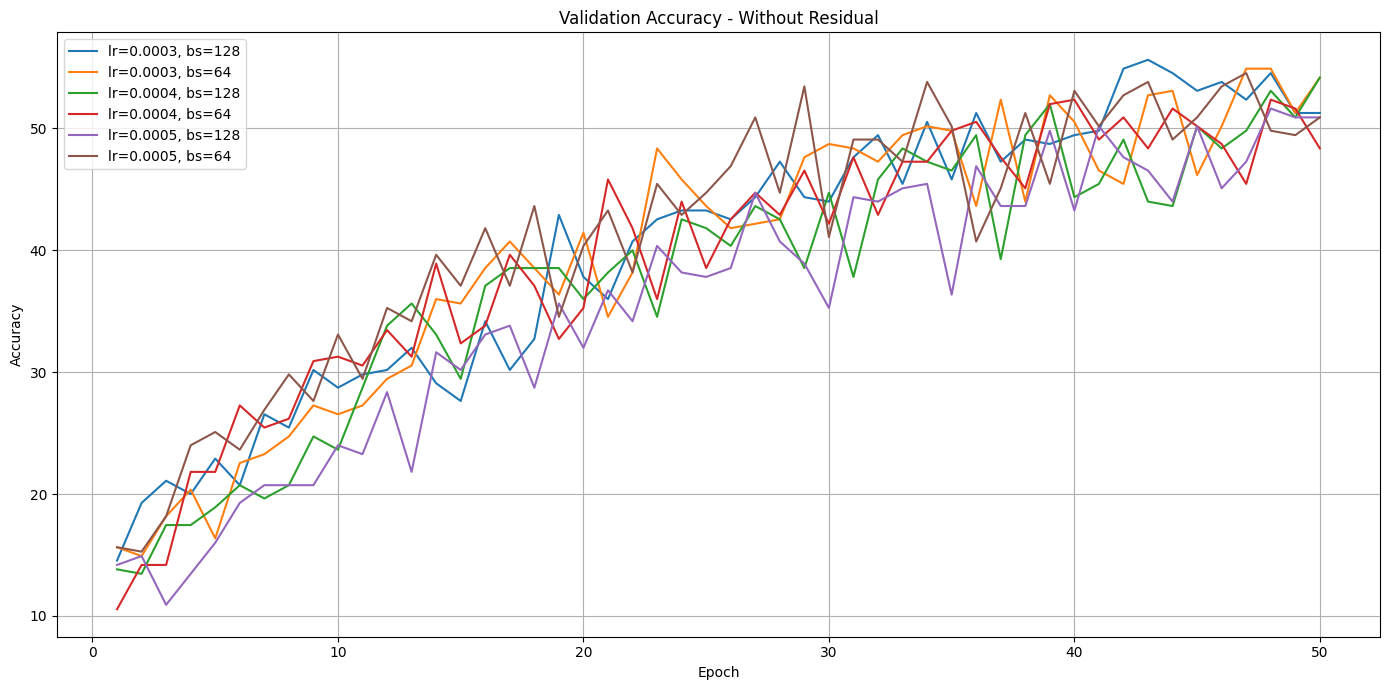

In [ ]:
draw_graphs(results, "Training Loss - Without Residual", "Validation Accuracy - Without Residual")

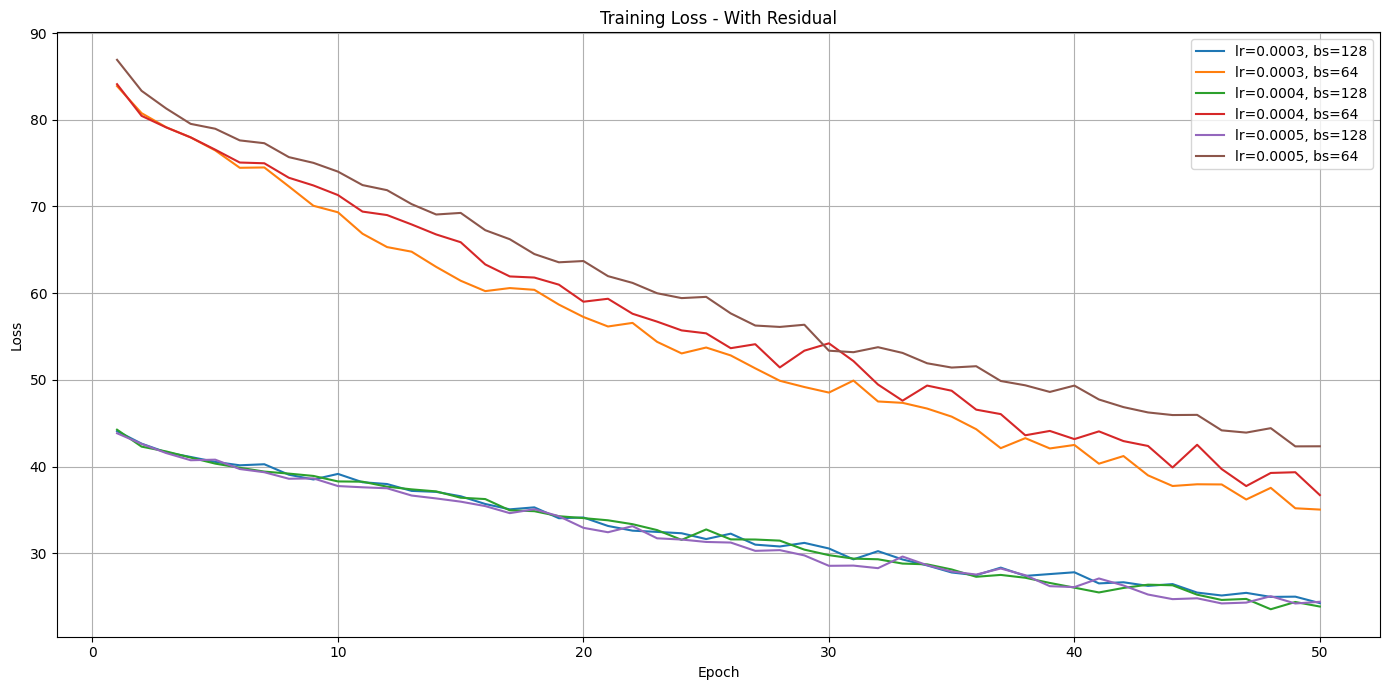

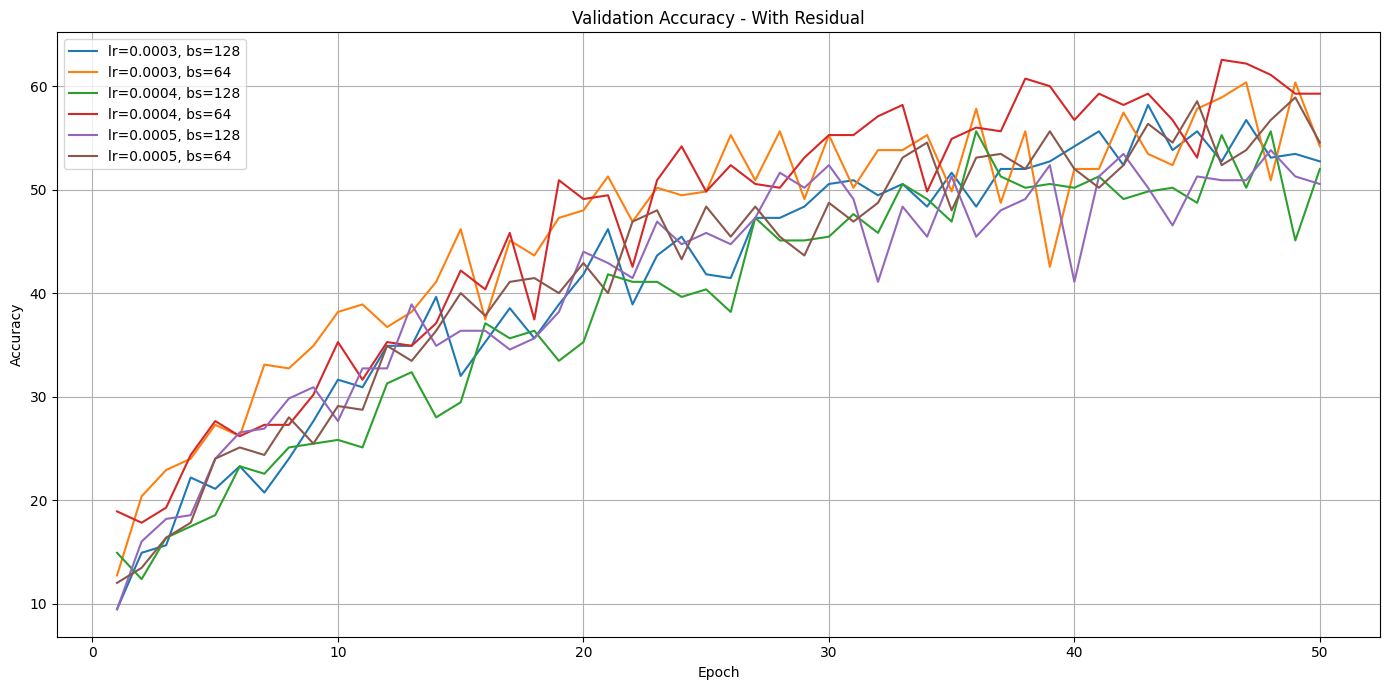

In [ ]:
draw_graphs(results_residual, "Training Loss - With Residual", "Validation Accuracy - With Residual")

In [13]:
class CNN_Dropout(nn.Module):
    def __init__(self, num_classes, p):
        super(CNN_Dropout, self).__init__()
        # channel widths for each conv
        C1, C2, C3, C4, C5 = 32, 64, 128, 256, 256

        self.features = nn.Sequential(
            # ── Conv 1 ── 256×256 → 256×256
            nn.Conv2d(3,  C1, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(C1),       # ← single BatchNorm
            nn.ReLU(),

            # ── Conv 2 ── 256×256 → 128×128
            nn.Conv2d(C1, C2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # ── Conv 3 ── 128×128 → 128×128
            nn.Conv2d(C2, C3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 4 ── 128×128 → 128×128
            nn.Conv2d(C3, C4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 5 ── 128×128 → 128×128
            nn.Conv2d(C4, C5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Single Pool ── 128×128 → 16×16
            nn.MaxPool2d(kernel_size=8),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C5 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [14]:
class CNN_Residual_Dropout(nn.Module):
    def __init__(self, num_classes, p):
        super(CNN_Residual_Dropout, self).__init__()
        # channel widths for each conv
        C1, C2, C3, C4, C5 = 32, 64, 128, 256, 256

        self.first_block = nn.Sequential(
            # ── Conv 1 ── 256×256 → 256×256
            nn.Conv2d(3,  C1, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(C1),       # ← single BatchNorm
            nn.ReLU(),

            # ── Conv 2 ── 256×256 → 128×128
            nn.Conv2d(C1, C2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # ── Conv 3 ── 128×128 → 128×128
            nn.Conv2d(C2, C3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # ── Conv 4 ── 128×128 → 128×128
            nn.Conv2d(C3, C4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.second_block = nn.Sequential(
            # ── Conv 5 ── 128×128 → 128×128
            nn.Conv2d(C4, C5, kernel_size=3, stride=1, padding=1),
        )
        self.third_block = nn.Sequential(
            nn.ReLU(),

            # ── Single Pool ── 128×128 → 16×16
            nn.MaxPool2d(kernel_size=8),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(C5 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.first_block(x)
        out = self.second_block(x)
        out = out + x
        out = self.third_block(out)
        out = self.classifier(out)
        return out


In [15]:
test_dataset = datasets.ImageFolder(root="food11/test", transform=transform_val)

In [16]:
def test_model2(batch_size, learning_rate, model):
    result = {}

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)

    val_accs = []
    test_accs = []
    train_losses = []

    for epoch in tqdm(range(num_epochs), desc=f"Epoch: "):  # Number of epochs
        model.train()
        train_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_correct, val_total, test_correct, test_total = 0, 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_accs.append(100 * val_correct / val_total)

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

            test_accs.append(100 * test_correct / test_total)

    result["loss"] = train_losses
    result["val_accuracy"] = val_accs
    result["test_accuracy"] = test_accs

    return result

In [ ]:
model = CNN(num_classes).to(device)

result = test_model2(64, 0.0003, model)

del model
torch.cuda.empty_cache()
gc.collect()

model = CNN_Residual(num_classes).to(device)

result_residual = test_model2(64, 0.0004, model)

del model
torch.cuda.empty_cache()
gc.collect()

Epoch: 100%|██████████| 50/50 [39:28<00:00, 47.38s/it]


0

In [ ]:
print(result["test_accuracy"][-1])
print(result_residual["test_accuracy"][-1])

43.27272727272727
50.90909090909091


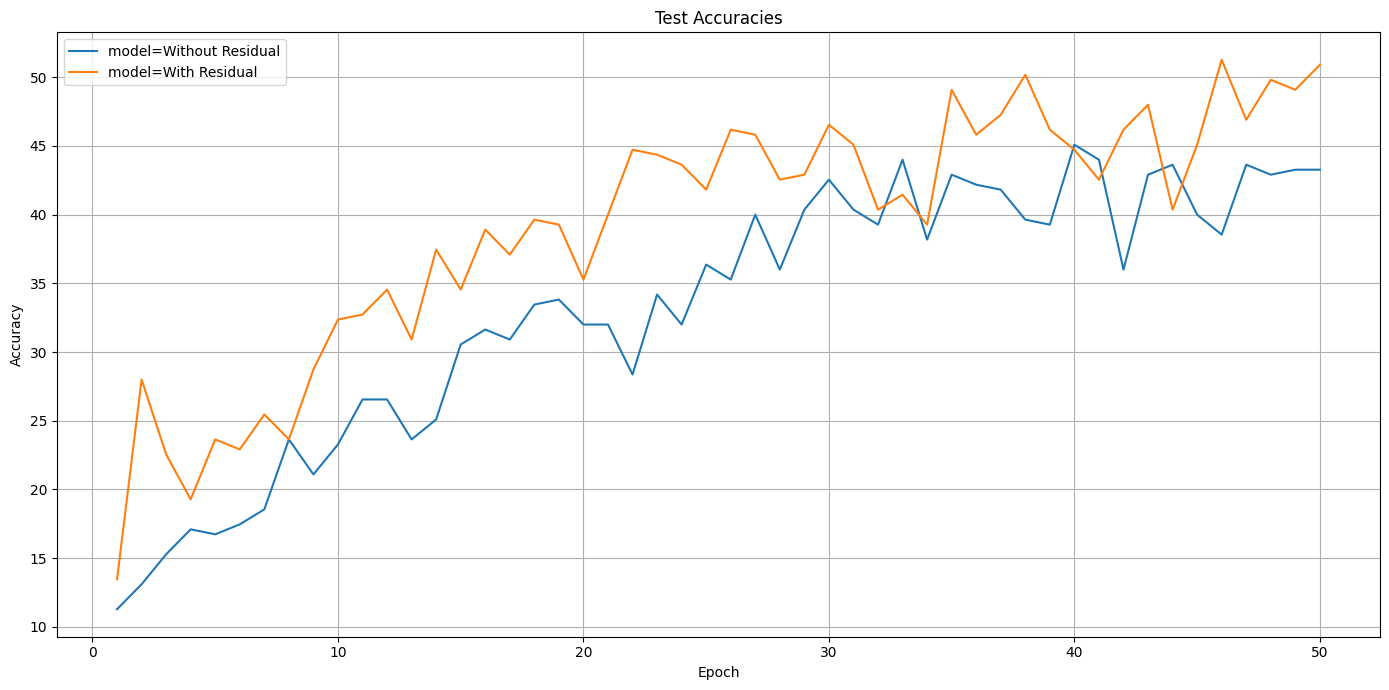

In [ ]:
# Test Accuracy
epochs = range(1, 51)
plt.figure(figsize=(14, 7))
plt.plot(epochs, result["test_accuracy"], label=f"model=Without Residual")
plt.plot(epochs, result_residual["test_accuracy"], label=f"model=With Residual")
plt.title("Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
p_vals = [0.3, 0.5]

results = {}

for p in p_vals:
    model = CNN_Dropout(num_classes, p).to(device)
    results[p] = test_model2(64, 0.0003, model)

    del model
    torch.cuda.empty_cache()
    gc.collect()


results_residual = {}

for p in p_vals:
    model = CNN_Residual_Dropout(num_classes, p).to(device)
    results_residual[p] = test_model2(64, 0.0004, model)

    del model
    torch.cuda.empty_cache()
    gc.collect()

Epoch: 100%|██████████| 50/50 [28:34<00:00, 34.29s/it]


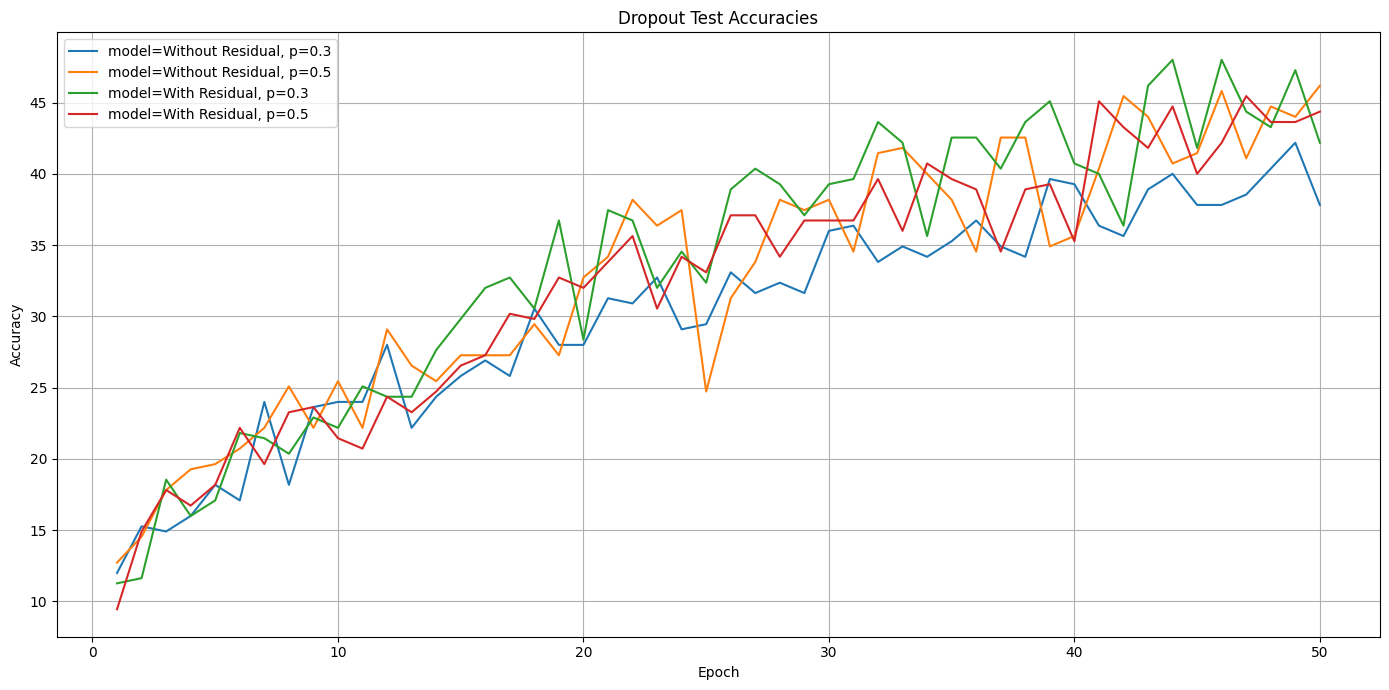

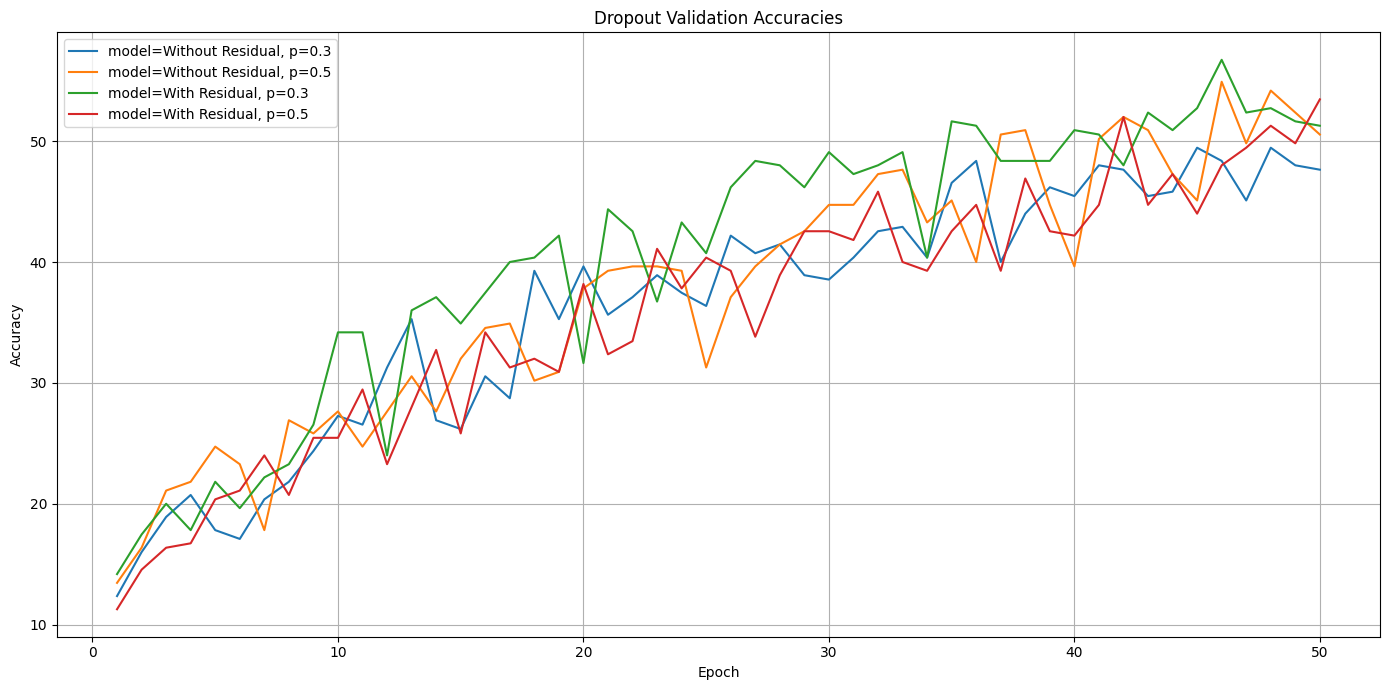

In [ ]:
epochs = range(1, 51)

# Test Accuracy
plt.figure(figsize=(14, 7))
for p, res in results.items():
    plt.plot(epochs, res["test_accuracy"], label=f"model=Without Residual, p={p}")
for p, res in results_residual.items():
    plt.plot(epochs, res["test_accuracy"], label=f"model=With Residual, p={p}")
plt.title("Dropout Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation Accuracy
plt.figure(figsize=(14, 7))
for p, res in results.items():
    plt.plot(epochs, res["val_accuracy"], label=f"model=Without Residual, p={p}")
for p, res in results_residual.items():
    plt.plot(epochs, res["val_accuracy"], label=f"model=With Residual, p={p}")
plt.title("Dropout Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
best_model = CNN_Residual(num_classes).to(device)
_, _, _ = test_model2(64, 0.0004, best_model)

Epoch: 100%|██████████| 50/50 [39:08<00:00, 46.96s/it]


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

y_true = []
y_pred = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

In [ ]:
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i].cpu()
  y_true[i] = y_true[i].cpu()

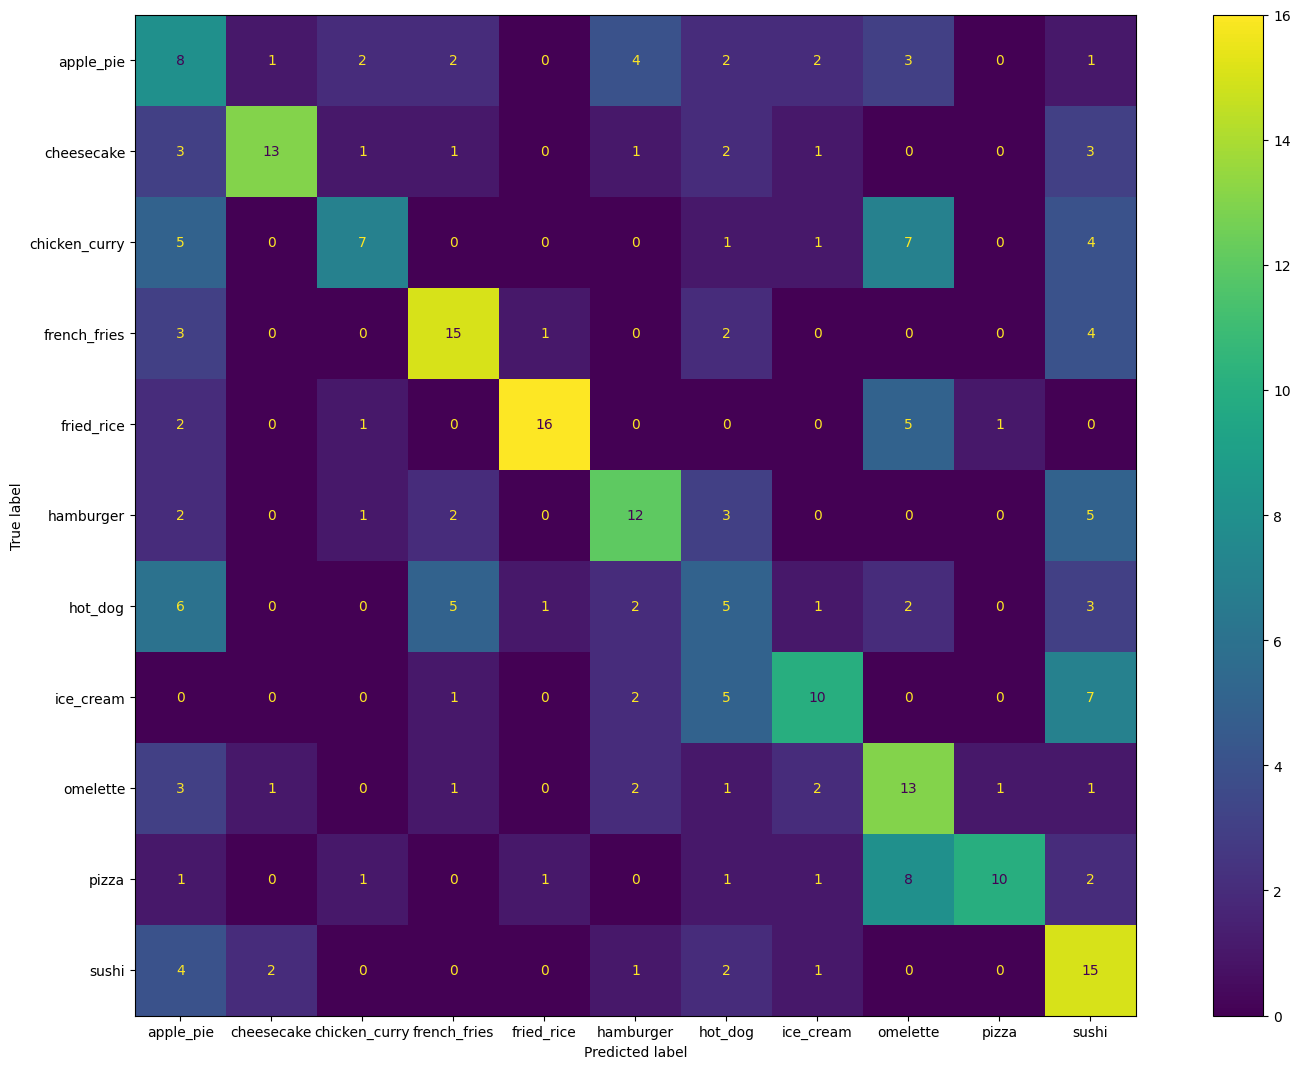

In [ ]:
label_names = ["apple_pie", "cheesecake", "chicken_curry", "french_fries", "fried_rice", "hamburger", "hot_dog", "ice_cream", "omelette", "pizza", "sushi"]
conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=label_names)
fig, ax = plt.subplots(figsize=(20, 13))
cm_display.plot(ax=ax)
plt.show()

# Part 2

In [17]:
def get_mobilenetv3_case1(num_classes):
    """
    Loads MobileNetV3 and freezes all layers except the final fully-connected layer.
    """
    # Load pretrained model
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier's final Linear layer to match num_classes
    # The classifier is nn.Sequential([... , Linear(in_features, 1000)])
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)

    # Unfreeze only the new FC layer
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [18]:
def get_mobilenetv3_case2(num_classes):
    """
    Loads MobileNetV3 and freezes all layers except the last two convolutional blocks and the final FC layer.
    """
    # Load pretrained model
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Identify and unfreeze the last two convolutional blocks
    # model.features is an nn.Sequential of blocks; we take the last two
    for block in list(model.features.children())[-2:]:
        for param in block.parameters():
            param.requires_grad = True

    # Replace the classifier's final Linear layer
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)

    # Unfreeze classifier parameters
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [19]:
mobilenetv3_case1 = get_mobilenetv3_case1(num_classes).to(device)
result_case1 = test_model2(64, 0.0004, mobilenetv3_case1)

mobilenetv3_case2 = get_mobilenetv3_case2(num_classes).to(device)
result_case2 = test_model2(64, 0.0004, mobilenetv3_case2)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 62.3MB/s]
Epoch: 100%|██████████| 50/50 [23:38<00:00, 28.37s/it]


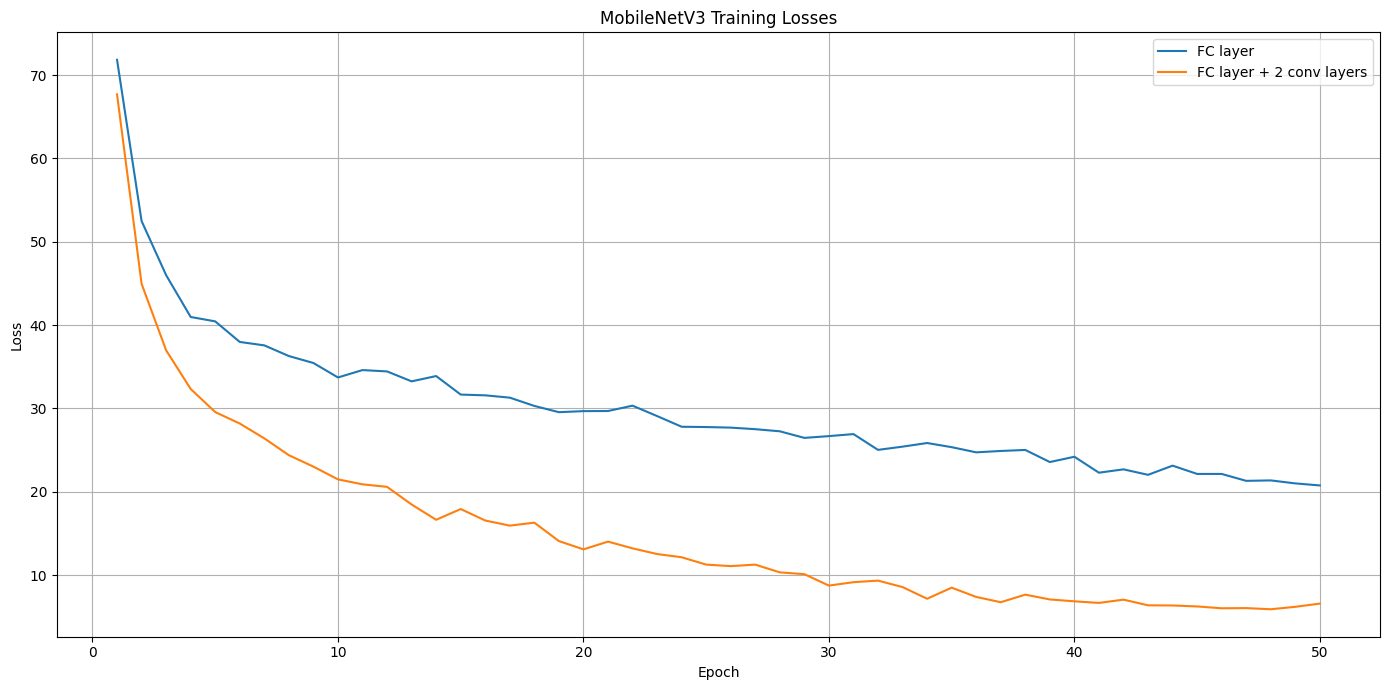

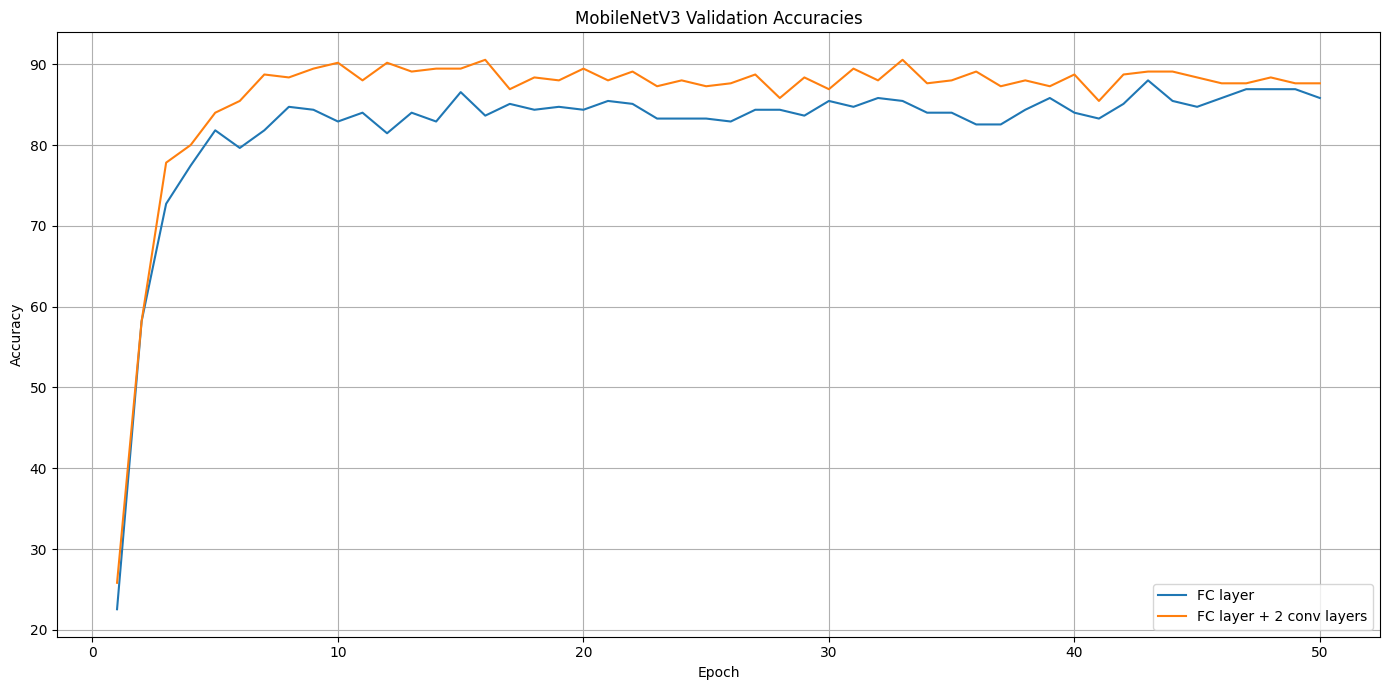

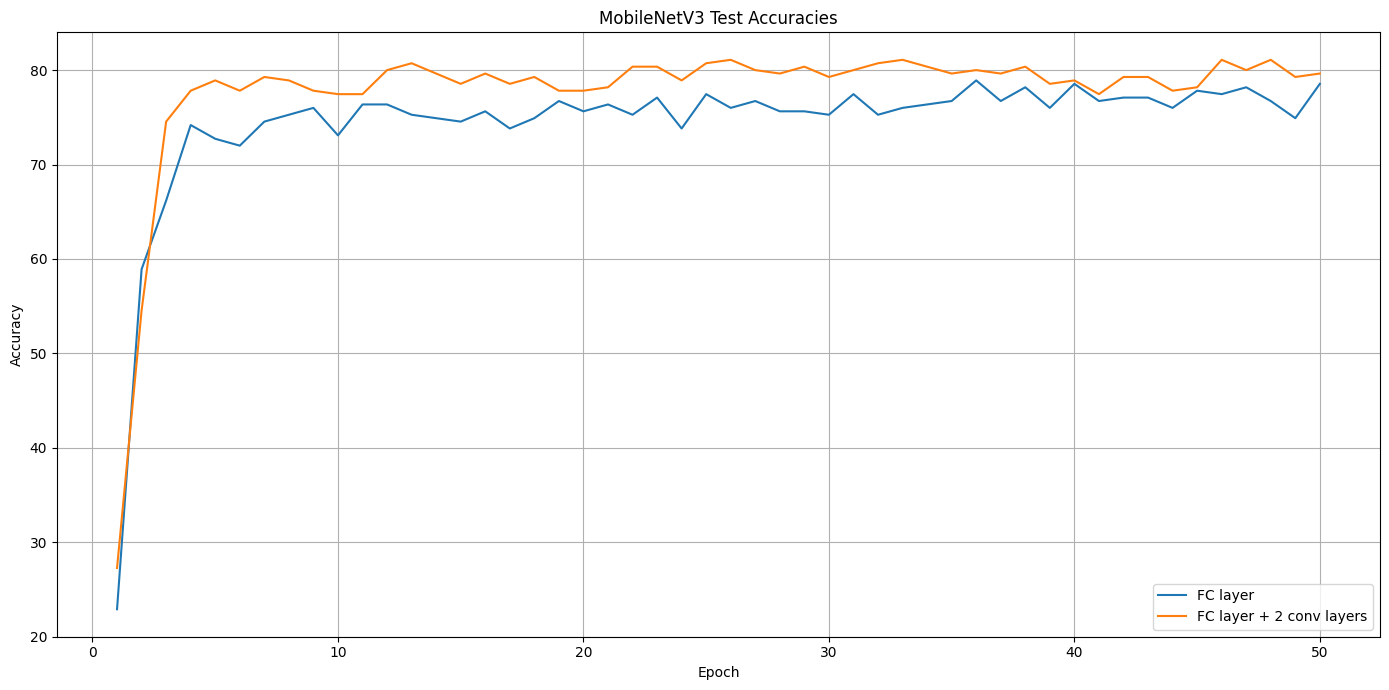

In [20]:
epochs = range(1, 51)

# Training Loss
plt.figure(figsize=(14, 7))
plt.plot(epochs, result_case1["loss"], label=f"FC layer")
plt.plot(epochs, result_case2["loss"], label=f"FC layer + 2 conv layers")
plt.title("MobileNetV3 Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation Accuracy
plt.figure(figsize=(14, 7))
plt.plot(epochs, result_case1["val_accuracy"], label=f"FC layer")
plt.plot(epochs, result_case2["val_accuracy"], label=f"FC layer + 2 conv layers")
plt.title("MobileNetV3 Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test Accuracy
plt.figure(figsize=(14, 7))
plt.plot(epochs, result_case1["test_accuracy"], label=f"FC layer")
plt.plot(epochs, result_case2["test_accuracy"], label=f"FC layer + 2 conv layers")
plt.title("MobileNetV3 Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

y_true = []
y_pred = []

mobilenetv3_case2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenetv3_case2(images)

        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

In [22]:
for i in range(len(y_pred)):
  y_pred[i] = y_pred[i].cpu()
  y_true[i] = y_true[i].cpu()

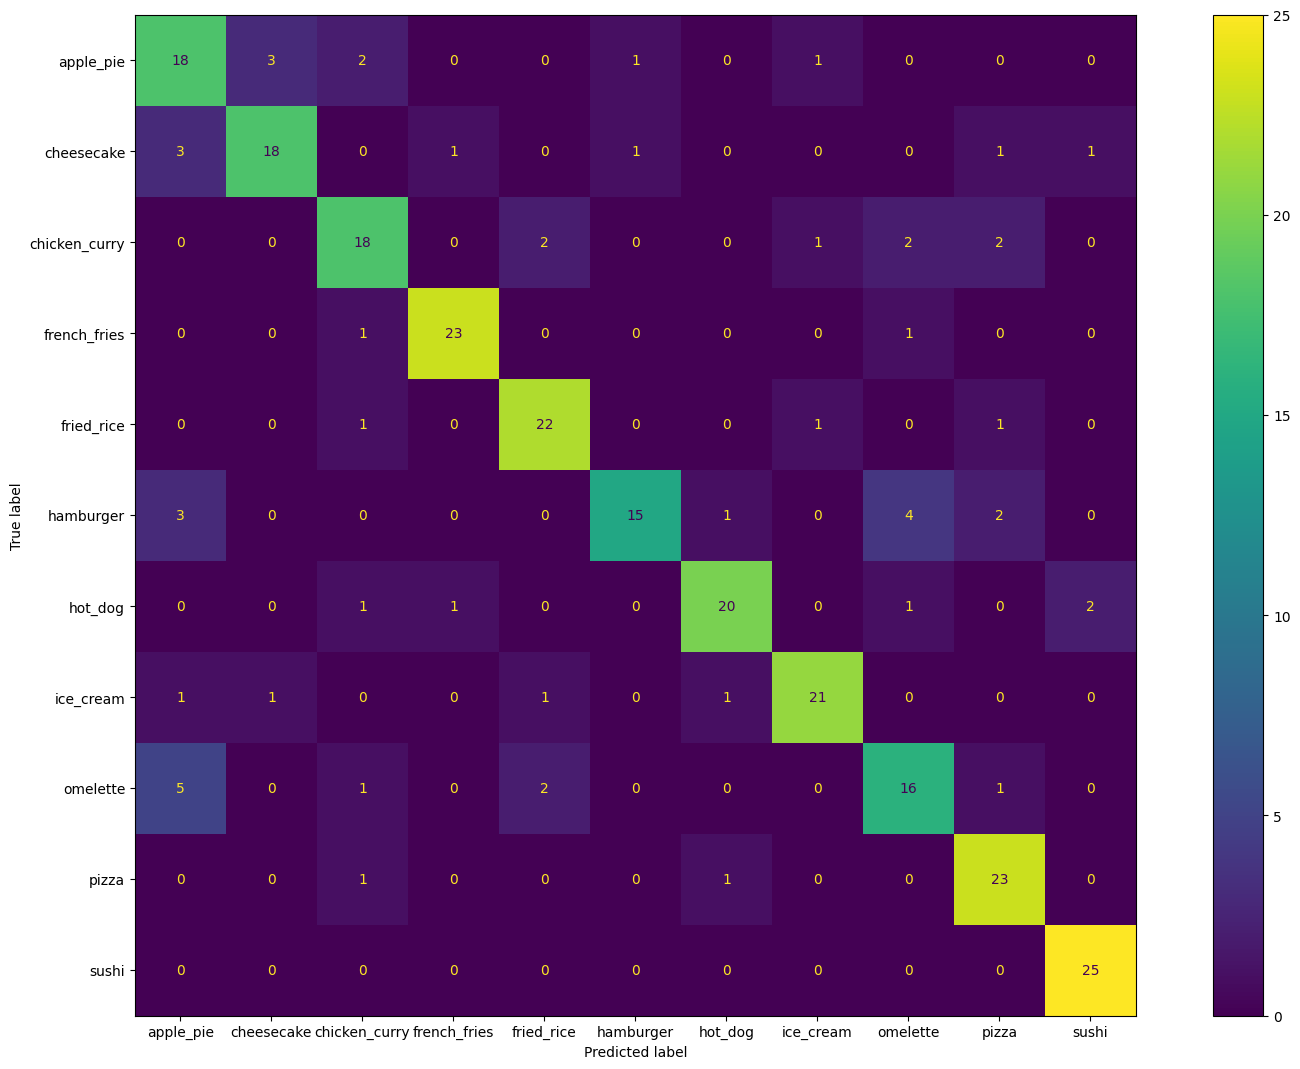

In [23]:
label_names = ["apple_pie", "cheesecake", "chicken_curry", "french_fries", "fried_rice", "hamburger", "hot_dog", "ice_cream", "omelette", "pizza", "sushi"]
conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=label_names)
fig, ax = plt.subplots(figsize=(20, 13))
cm_display.plot(ax=ax)
plt.show()